In [1]:
%env THEANO_FLAGS='device=gpu0','floatX=float32'

import os
import os.path as osp

import numpy as np

import theano
import theano.tensor as T
from lasagne import *

%matplotlib nbagg
import matplotlib.pyplot as plt

from mldm import Watcher, Net, CAE

env: THEANO_FLAGS='device=gpu0','floatX=float32'


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
%%sh

wget -q -nc https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py

In [3]:
### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnist

In [4]:
%%sh

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip *.gz
}

gzip: t10k-images-idx3-ubyte already exists;	not overwritten
gzip: t10k-labels-idx1-ubyte already exists;	not overwritten
gzip: train-images-idx3-ubyte already exists;	not overwritten
gzip: train-labels-idx1-ubyte already exists;	not overwritten


In [5]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.reshape(-1, 1, 28, 28).astype('float32')

X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')

In [6]:
cae = CAE(n_codes=16)

In [ ]:
PATH = "CAE_%d.npz" % cae.n_codes

try:
    cae.load(PATH)
except Exception as e:
    print e
    print 'Failed to load network weights.'

mismatch: parameter has shape (32, 16, 3, 3) but value to set has shape (16, 32, 3, 3)
Failed to load network weights.


<IPython.core.display.Javascript object>


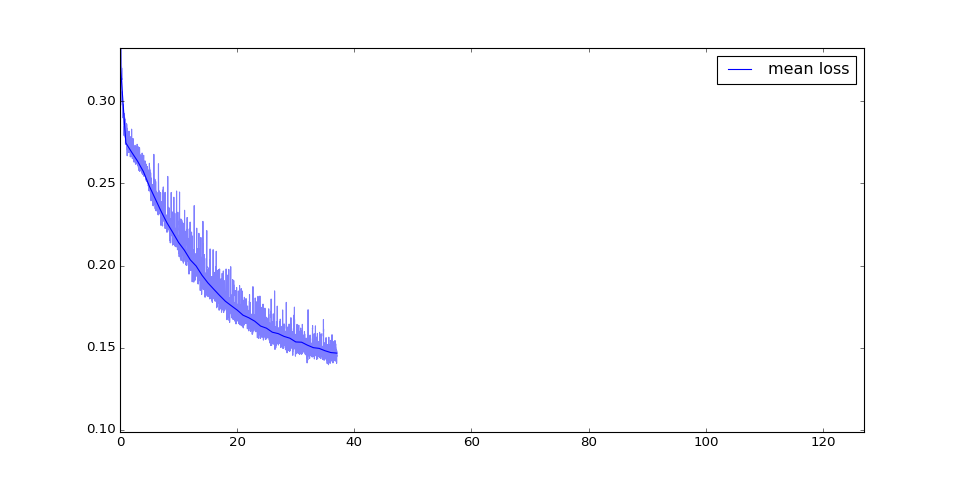

In [ ]:
watcher = Watcher(epoches=128)
ls = cae.fit(X, n_epoches=128, batch_size=2**9, loss='log', learning_rate=1.0, watcher=watcher)

cae.save(PATH)

In [ ]:
import itertools
n_codes_side = 4
n_codes = 16

nrows, ncols = 1, 9

indx = np.random.choice(X_test.shape[0], size=ncols, replace=False)
codes = cae.encode(X_test[indx])
X_rec = cae.reconstruct(X_test[indx])

fig, ax = plt.subplots(nrows * 3, ncols, figsize=(ncols * 2 , nrows * 6))

for i, j in itertools.product(range(nrows), range(ncols)):
    ax[i * 3, j].imshow(
        X_test[indx[j], 0],
        interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0
    )
    ax[i * 3, j].set_title('A sample')
    
    ax[i * 3 + 1, j].imshow(
        X_rec[j, 0],
        interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0
    )
    ax[i * 3 + 1, j].set_title('Reconstructed')
    
    
    ax[i * 3 + 2, j].imshow(
        codes[j].reshape(n_codes_side, n_codes_side),
        interpolation='None', cmap=plt.cm.viridis, vmin=0.0, vmax=np.max(codes)
    )
    ax[i * 3 + 2, j].set_title('Code space')

fig.tight_layout()
plt.show()

In [ ]:
code_test = cae.encode(X_test)

In [ ]:
max_code = np.max(code_test)

In [ ]:
fig, ax = plt.subplots(n_codes_side, n_codes_side, figsize=(12, 12))

for i, j in itertools.product(range(n_codes_side), range(n_codes_side)):
    fn = i * 4 + j
    ax[i, j].hist(code_test[:, fn], bins=20, log=True)

plt.show()

In [ ]:
import itertools

nrows, ncols = 7, 7

codes = np.random.uniform(size=(nrows, ncols, n_codes)).astype('float32') * max_code
X_rec = cae.decode(codes.reshape(-1, n_codes)).reshape(nrows, ncols, 28, 28)

fig, ax = plt.subplots(nrows * 2, ncols, figsize=((ncols + 1) * 2, (nrows + 2) * 3))

for i, j in itertools.product(range(nrows), range(ncols)):
    ax[i * 2, j].imshow(
        X_rec[i, j],
        interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0
    )
    
    ax[i * 2 + 1, j].imshow(
        codes[i, j].reshape(n_codes_side, n_codes_side),
        interpolation='None', cmap=plt.cm.viridis, vmin=0.0, vmax=max_code
    )

plt.show()

In [ ]:
import itertools

m = 11

alpha = np.linspace(0.0, 1.0, num=m)

for i in range(5):
    indx1, indx2 = np.random.choice(X_test.shape[0], size=2, replace=False)

    code1 = cae.encode(X_test[indx1].reshape(-1, 1, 28, 28))
    code2 = cae.encode(X_test[indx2].reshape(-1, 1, 28, 28))
    
    fig, ax = plt.subplots(1, 2, figsize=(4, 2), squeeze=True)
    ax[0].imshow(
        X_test[indx1, 0],
        interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0
    )
    
    ax[1].imshow(
        X_test[indx2, 0],
        interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0
    )
    plt.show()
    
    fig, ax = plt.subplots(2, m, figsize=((m + 1) * 3, 7), squeeze=False)
    
    for j in range(m):
        code = (1.0 - alpha[j]) * code1 + alpha[j] * code2
        X_merged = cae.decode(code)
        
        ax[0, j].imshow(
            X_merged[0, 0],
            interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0
        )
    
    for j in range(m):
        X_merged = (1.0 - alpha[j]) * X_test[indx1] + alpha[j] * X_test[indx2]
        
        ax[1, j].imshow(
            X_merged[0],
            interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0
        )
    
    plt.show()